In [8]:
import os
import re
import numpy as np
import pandas as pd
import textwrap
import pickle
import torch
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [1]:
import moses

ModuleNotFoundError: No module named 'moses'

In [4]:
device = "cuda:1"

In [5]:
tokenizer = AutoTokenizer.from_pretrained("/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

tokenizer size:  50066


In [6]:
checkpoint_path = "/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
checkpoint_path

'/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/'

In [7]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

model loaded with embedding size of : 50066


In [41]:
moses = pd.read_csv('./data/dataset_v1.csv')
moses.head()

,SMILES,SPLIT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train


In [42]:
moses = moses[moses.SPLIT == 'train']
moses.head()

,SMILES,SPLIT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train


In [43]:
moses[['SAS', 'QED', 'CLOGP', 'WEIGHT']] = 0

In [44]:
moses.head()

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,0,0,0,0
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,0,0,0,0
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,0,0,0,0
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,0,0,0,0
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,0,0,0,0


In [45]:
for en, mol in enumerate(moses.iloc[:,0]):
          mol_source = Chem.MolFromSmiles(mol)
          sas_score = sascorer.calculateScore(mol_source) 
          qed_score = round(QED.qed(mol_source), 3)
          clogp_score = round(Descriptors.MolLogP(mol_source), 3)
          weight_score = round(Descriptors.ExactMolWt(mol_source), 3)
          moses.iloc[en, 2] = sas_score
          moses.iloc[en, 3] = qed_score
          moses.iloc[en, 4] = clogp_score
          moses.iloc[en, 5] = weight_score

/tmp/ipykernel_1689974/3029114970.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.812618487593367' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  moses.iloc[en, 2] = sas_score
/tmp/ipykernel_1689974/3029114970.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.897' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  moses.iloc[en, 3] = qed_score
/tmp/ipykernel_1689974/3029114970.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.681' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  moses.iloc[en, 4] = clogp_score
/tmp/ipykernel_1689974/3029114970.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future

KeyboardInterrupt: 

In [47]:
moses.head(2000)

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,3.055750,0.853,0.807,271.061
...,...,...,...,...,...,...
2400,CC(=O)NC1(C(Cl)(Cl)Cl)Oc2ccccc2O1,train,2.917217,0.810,2.618,294.957
2402,CC(=O)NC1(C(F)(F)F)Oc2cc(Cl)c(Cl)cc2O1,train,2.835251,0.866,3.117,314.968
2403,Brc1cccc(-c2nnc3n2CCC3)c1,train,2.148228,0.792,2.654,263.006
2404,Cc1ccc(C(=O)Cn2nnc(-c3ccccc3)n2)cc1,train,1.856366,0.688,2.531,278.117


In [161]:
targets1, targets2, targets3, targets4, sas_scores, clogp_scores, qed_scores, weight_scores, sac_invalids, mols = [], [], [], [], [],[], [], [], [], []
for i in range(len(moses)):
          if i ==100:
                    break
          prompts = []
          mol, split, sas, qed, clogp, weight = moses.iloc[i,:]
          # print(sas, qed, clogp, weight)
          prompt = f"</s>[SAS]{sas:.2f}[/SAS][CLOGP]{clogp:.2f}[/CLOGP][QED]{qed:.2f}[/QED][WEIGHT]{weight:.2f}[/WEIGHT]"
          prompts.append(prompt)
          if len(propmts) == 10:

                    inputs = tokenizer(prompts, return_tensors="pt").input_ids
                    inputs = inputs.to(device)
                    context_length = inputs.shape[1]
          out = model.generate(inputs, max_new_tokens=300, do_sample=False,
                              #   top_p = 1.0, 
                              #   num_return_sequences=6,
                              #  num_beams=6, length_penalty=-5, renormalize_logits=True,
                              #   repetition_penalty=1.5, diversity_penalty=1., num_beam_groups=3, 
                              eos_token_id=20, return_dict_in_generate=True, output_scores=True)

          for seq in out.sequences:
                    decoded = tokenizer.decode(seq)
                    print('--------')
                    try:
                              left = "[START_SMILES]"
                              right = "[END_SMILES]"
                              captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
                              print(decoded)
                              # captured_text = re.match("^.*?(?=\\[END_SMILES])", tokenizer2.decode(out.sequences[0, context_length:])).group()
                              mol_source = Chem.MolFromSmiles(captured_text)
                              # score = Chem.Descriptors.HeavyAtomCount(mol_source)
                              sas_score = sascorer.calculateScore(mol_source) 
                              qed_score = round(QED.qed(mol_source), 3)
                              clogp_score = round(Descriptors.MolLogP(mol_source), 3)
                              weight_score = round(Descriptors.ExactMolWt(mol_source), 3)
                              # print(f'{target1=:.2f}', f'{target2=:.2f}', f'{sas_score=:.2f}', f'{clogp_score=:.2f}', captured_text)
                              print(f'{sas=:.2f}', f'{sas_score=:.2f}', f'{qed=:.2f}', f'{qed_score=:.2f}', f'{clogp=:.2f}', f'{clogp_score=:.2f}', f'{weight=:.2f}', f'{weight_score=:.2f}', captured_text)
                              targets1.append(sas)
                              targets2.append(clogp)
                              targets3.append(qed)
                              targets4.append(weight)
                              # sac_targets2.append(target2)
                              sas_scores.append(sas_score)
                              clogp_scores.append(clogp_score)
                              qed_scores.append(qed_score)
                              weight_scores.append(weight_score)
                              # sac_scores2.append(clogp_score)
                              mols.append(captured_text)
                              break
                    except:
                              continue
                              # sac_invalids.append((target1, target2))
        # print(f'{score:.2f}', decoded)
        # break

--------
</s>[SAS]3.81[/SAS][CLOGP]1.68[/CLOGP][QED]0.90[/QED][WEIGHT]281.08[/WEIGHT][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][NUMHACCEPTORS]4[/NUMHACCEPTORS][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]7[/NUMHETEROATOMS][HEAVYATOMCOUNT]19[/HEAVYATOMCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NOCOUNT]5[/NOCOUNT][START_SMILES]CC1=C(SC(=N1)N2CCCC(C2)C(=O)O)C(=O)C[END_SMILES]
sas=3.81 sas_score=2.70 qed=0.90 qed_score=0.85 clogp=1.68 clogp_score=1.96 weight=281.08 weight_score=268.09 CC1=C(SC(=N1)N2CCCC(C2)C(=O)O)C(=O)C
--------
</s>[SAS]2.94[/SAS][CLOGP]3.73[/CLOGP][QED]0.86[/QED][WEIGHT]292.10[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMALIPHATICHE

[18:06:22] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]2.99[/CLOGP][QED]0.81[/QED][WEIGHT]270.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMHACCEPTORS]3[/NUMHACCEPTORS][RINGCOUNT]1[/RINGCOUNT][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][IUPAC]2-[(2-fluorophenyl)methyl-methylamino]-2-methylpropanoic
[18:06:22] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]2.99[/CLOGP][QED]0.81[/QED][WEIGHT]270.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][

--------
</s>[SAS]1.68[/SAS][CLOGP]3.28[/CLOGP][QED]0.63[/QED][WEIGHT]274.08[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.13[/FRACTIONCSP3][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHACCEPTORS]2[/NUMHACCEPTORS][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][START_SMILES]C1=CC=C(C=C1)COC(=O)CCNC(=O)C2=CC=CC=C2[END_SMILES]
sas=1.68 sas_score=1.49 qed=0.63 qed_score=0.83 clogp=3.28 clogp_score=2.55 weight=274.08 weight_score=283.12 C1=CC=C(C=C1)COC(=O)CCNC(=O)C2=CC=CC=C2
--------
</s>[SAS]2.81[/SAS][CLOGP]3.10[/CLOGP][QED]0.85[/QED][WEIGHT]320.01[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.25[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATA

[18:06:24] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]1.02[/CLOGP][QED]0.71[/QED][WEIGHT]254.12[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]2[/NUMHDONORS][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][RINGCOUNT]1[/RINGCOUNT][NUMHACCEPTORS]4[/NUMHACCEPTORS][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][IUPAC]2-[(2-amino-3-methylbutanoyl)-methylamino]-4-fluorobenzoic
[18:06:24] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]1.02[/CLOGP][QED]0.71[/QED][WEIGHT]254.12[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]2[/NUMHDONORS][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][RINGCOUNT]1[/RINGCOUNT][NUMHACCEPTORS]4[/NUMHACCEPTO

--------
</s>[SAS]3.30[/SAS][CLOGP]1.09[/CLOGP][QED]0.83[/QED][WEIGHT]274.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHETEROATOMS]5[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][IUPAC]2-[(2S)-2-(2-fluorophenyl)-2-methyl-3-oxopiperazin-1-yl]-N-methylpropanamide[/IUPAC][NOCOUNT]5[/NOCOUNT][HEAVYATOMCOUNT]20[/HEAVYATOMCOUNT][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)


[18:06:25] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]1.09[/CLOGP][QED]0.83[/QED][WEIGHT]274.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHETEROATOMS]5[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][IUPAC]2-[(2S)-2-(2-fluorophenyl)-2-methyl-3-oxopiperazin-1-yl]-N-methylpropanamide[/IUPAC][NOCOUNT]5[/NOCOUNT][HEAVYATOMCOUNT]20[/HEAVYATOMCOUNT][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F
[18:06:25] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]1.09[/CLOGP][QED]0.83[/QED][WEIGHT]274.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[

--------
</s>[SAS]3.79[/SAS][CLOGP]1.04[/CLOGP][QED]0.79[/QED][WEIGHT]262.10[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMHETEROATOMS]7[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHACCEPTORS]5[/NUMHACCEPTORS][NOCOUNT]7[/NOCOUNT][HEAVYATOMCOUNT]19[/HEAVYATOMCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][IUPAC]2-[(2S)-2-(2-methyl-1,3-thiazol-4-yl)-2-oxo-1,3-oxazolidin-3-yl]butanoic acid[/IUPAC][NUMSATURATEDRINGS]1[/NUMSATURATEDRINGS][NUMALIPHATICRINGS]1[/NUMALIPHATICRINGS][TPSA]88.83[/TPSA][START_SMILES]CCC(C(=O)O)N1[C@H](COC1=O)C2=CSC(=N2)C[END_SMILES]
sas=3.79 sas_score=3.72 qed=0.79 qed_score=0.90 clogp=1.04 clogp_score=1.81 weight=262.10 weight_score=270.07 CCC(

[18:06:29] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]2.89[/CLOGP][QED]0.86[/QED][WEIGHT]319.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.28[/FRACTIONCSP3][NUMHACCEPTORS]4[/NUMHACCEPTORS][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][IUPAC]N-[(2S)-1-(dimethylamino)-1-oxopropan-2-yl]-2-(4-methylphenyl)-1,3-thiazole-4-carboxamide[/IUPAC][SIMILAR]CC1=CC=C(C=C1)C2=NC(=CS2)C(=O)NCC(=O)N3CCCC3
[18:06:29] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]2.89[/CLOGP][QED]0.86[/QED][WEIGHT]319.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLE

--------
</s>[SAS]3.39[/SAS][CLOGP]0.88[/CLOGP][QED]0.75[/QED][WEIGHT]289.03[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMHACCEPTORS]5[/NUMHACCEPTORS][NUMHETEROATOMS]8[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NOCOUNT]6[/NOCOUNT][START_SMILES]C1COCC1(C(=O)O)N2C=C(C=N2)Br[END_SMILES]
sas=3.39 sas_score=3.76 qed=0.75 qed_score=0.86 clogp=0.88 clogp_score=0.85 weight=289.03 weight_score=259.98 C1COCC1(C(=O)O)N2C=C(C=N2)Br
--------
</s>[SAS]2.71[/SAS][CLOGP]2.47[/CLOGP][QED]0.88[/QED][WEIGHT]300.07[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABL

[18:06:32] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]3.77[/CLOGP][QED]0.86[/QED][WEIGHT]308.15[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.35[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NOCOUNT]3[/NOCOUNT][IUPAC]N-[(2-fluorophenyl)methyl]-2-methyl-2-(2-methylpropyl)-1,3-thiazol-4-amine[/IUPAC][SIMILAR]CC1=NC(=CS1)CNC2=CC=CC=C2F
[18:06:32] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]3.77[/CLOGP][QED]0.86[/QED][WEIGHT]308.15[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRAC

--------
</s>[SAS]1.73[/SAS][CLOGP]2.44[/CLOGP][QED]0.90[/QED][WEIGHT]332.08[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.18[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][NOCOUNT]5[/NOCOUNT][START_SMILES]CC1=CC(=C(C=C1)OC)S(=O)(=O)NCC2=CC=CC=C2C#N[END_SMILES]
sas=1.73 sas_score=2.00 qed=0.90 qed_score=0.92 clogp=2.44 clogp_score=2.35 weight=332.08 weight_score=316.09 CC1=CC(=C(C=C1)OC)S(=O)(=O)NCC2=CC=CC=C2C#N
--------
</s>[SAS]2.05[/SAS][CLOGP]3.00[/CLOGP][QED]0.61[/QED][WEIGHT]258.09[/WEIGHT][NUMHDONORS]0[/NUMHDONORS][FRACTIONCSP3]0.07[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIP

[18:06:51] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]2.44[/CLOGP][QED]0.78[/QED][WEIGHT]323.13[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][FRACTIONCSP3]0.22[/FRACTIONCSP3][NUMHACCEPTORS]4[/NUMHACCEPTORS][NUMHDONORS]2[/NUMHDONORS][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][IUPAC]N-[2-(2-methoxyanilino)-2-oxoethyl]-2-methyl-3-nitrobenzamide[/IUPAC][NOCOUNT]6[/NOCOUNT][SIMILAR]CC1=C(C=C(C=C1)C(=O)NCC(=O)NC2=CC=CC=C2OC)[N+](=O)[O-]
[18:06:51] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]2.44[/CLOGP][QED]0.78[/QED][WEIGHT]323.13[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][NUMALIPHATICCAR

--------
</s>[SAS]2.30[/SAS][CLOGP]0.65[/CLOGP][QED]0.81[/QED][WEIGHT]294.08[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][NUMHACCEPTORS]5[/NUMHACCEPTORS][NUMHDONORS]2[/NUMHDONORS][RINGCOUNT]2[/RINGCOUNT][FRACTIONCSP3]0.23[/FRACTIONCSP3][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMHETEROATOMS]8[/NUMHETEROATOMS][NOCOUNT]7[/NOCOUNT][START_SMILES]CC1=C(C=C(C=C1)S(=O)(=O)NCC2=NC=NN2)C(=O)O[END_SMILES]
sas=2.30 sas_score=2.28 qed=0.81 qed_score=0.73 clogp=0.65 clogp_score=0.29 weight=294.08 weight_score=296.06 CC1=C(C=C(C=C1)S(=O)(=O)NCC2=NC=NN2)C(=O)O
--------
</s>[SAS]2.07[/SAS][CLOGP]1.17[/CLOGP][QED]0.81[/QED][WEIGHT]264.07[/WEIGHT][NUMHDONORS]2[/NUMHDONORS][FRACTIONCSP3]0.25[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHA

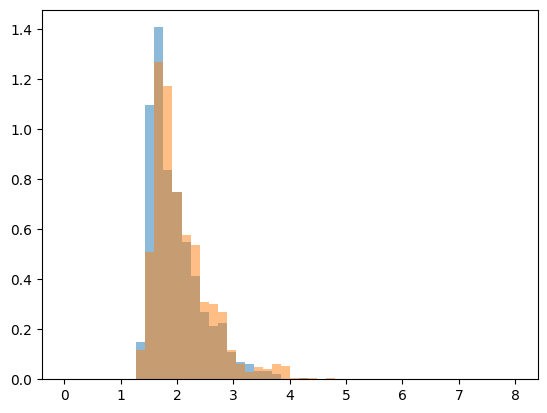

In [154]:
plt.hist(sas_scores, range=(0,8), bins=50, alpha=.5, density=True);
plt.hist(targets1, range=(0,8), bins=50, alpha=.5, density=True);

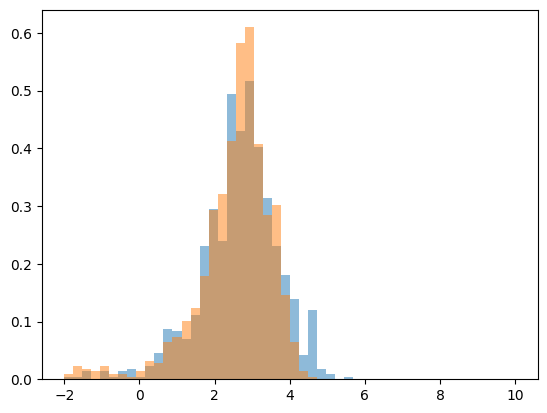

In [155]:
plt.hist(clogp_scores, range=(-2,10), bins=50, alpha=.5, density=True);
plt.hist(targets2, range=(-2,10), bins=50, alpha=.5, density=True);

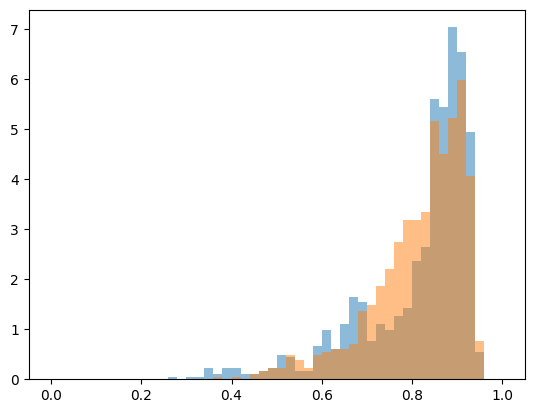

In [156]:
plt.hist(qed_scores, range=(0,1), bins=50, alpha=.5, density=True);
plt.hist(targets3, range=(0,1), bins=50, alpha=.5, density=True);

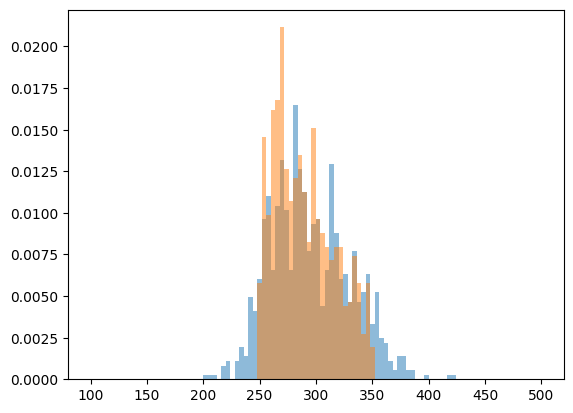

In [157]:
plt.hist(weight_scores, range=(100,500), bins=100, alpha=.5, density=True);
plt.hist(targets4, range=(100,500), bins=100, alpha=.5, density=True);

In [160]:
(np.array(targets4) < 250).sum()

0

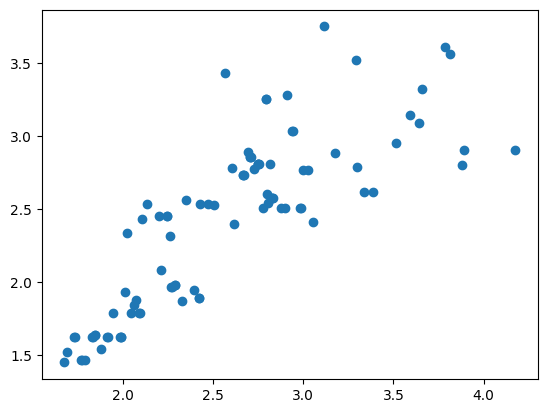

In [108]:
plt.scatter(sac_targets1, sac_scores)

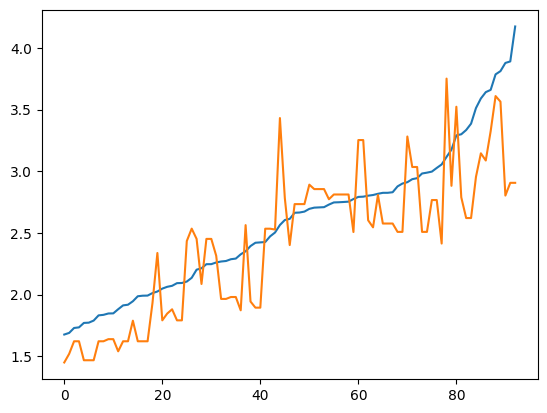

In [114]:
plt.plot(sorted(zip(sac_targets1, sac_scores)))

In [85]:
for _, sas, qed, clogp, weight in moses.iloc[1:10,[2,3,4,5]]:
          # mol, split, sas, qed, clogp, weight = sample
          print(sas, qed, clogp, weight)

ValueError: not enough values to unpack (expected 5, got 3)

In [100]:

for i in range(len(moses)):
          a,v=moses.iloc[i,3:5]
          print(a,v)
          break

0.897 1.681
